### Class 10 - Image encoding and classification using CNNs and ViT
In this class, we will use pretrained CNN and transformer models to encode and classify images.
We will use a library you are familiar with, namely Hugging Face's _transformers_, as well as (under the hood) _timm_ (another HuggingFace library, specific to computer vision) and _pytorch_.

**A few notes**
- We will not be fine-tuning CV models in this class, only simple neural networks that take their encodings as input. If fine-tuning a model more substantially is needed, plenty of tutorials are available for tasks ranging from image classification, object detection, image segmentation, etc. Look up _timm_'s documentation (https://huggingface.co/docs/hub/en/timm) and _transformers_'s documentation (https://huggingface.co/docs/transformers/tasks/image_classification);
- We are not training a CNN from scratch, here, but if you want to do so, you can look up, for example, _Pytorch_'s intro tutorial (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). There are a ton of resources online if this is what you decide to focus on in your final projects;
- If you want to use images as part of a more complex dataset for your final projects, and what you are after is doing segmentation or classification, you will often be able to use pretrained CNNs or ViT models from Hugging Face's hub. If you are working with "special" image data (e.g., medical data), consider going through the Model Hub (https://huggingface.co/models) to check if any domain-specific pretrained models are available. Otherwise, you will probably have to train your own model. 

### Load dataset

In [432]:
from datasets import load_dataset
from collections import Counter

from transformers import AutoImageProcessor, ResNetModel

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim

from sklearn.manifold import TSNE

from torchview import draw_graph

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
dataset_name = 'Matthijs/snacks'
data = load_dataset(dataset_name)

In [364]:
train = data['train']
test = data['test']

In [365]:
train, test

(Dataset({
     features: ['image', 'label'],
     num_rows: 4838
 }),
 Dataset({
     features: ['image', 'label'],
     num_rows: 952
 }))

Visualizing the frequency of different labels

In [473]:
train_counts = pd.DataFrame.from_dict(Counter(train['label']), orient='index').reset_index()
test_counts = pd.DataFrame.from_dict(Counter(test['label']), orient='index').reset_index()
train_counts['split'] = 'train'
test_counts['split'] = 'test'
all_counts = pd.concat([train_counts, test_counts])

In [474]:
label_dict = {0: 'apple',
              1: 'banana',
              2: 'cake',
              3: 'candy',
              4: 'carrot',
              5: 'cookie',
              6: 'doughnut',
              7: 'grape',
              8: 'hotdog',
              9: 'icecream',
              10: 'juice',
              11: 'muffin',
              12: 'orange',
              13: 'pineapple',
              14: 'popcorn',
              15: 'pretzel',
              16: 'salad',
              17: 'strawberry',
              18: 'waffle',
              19: 'watermelon'}

In [475]:
all_counts['index'] = all_counts['index'].map(label_dict)

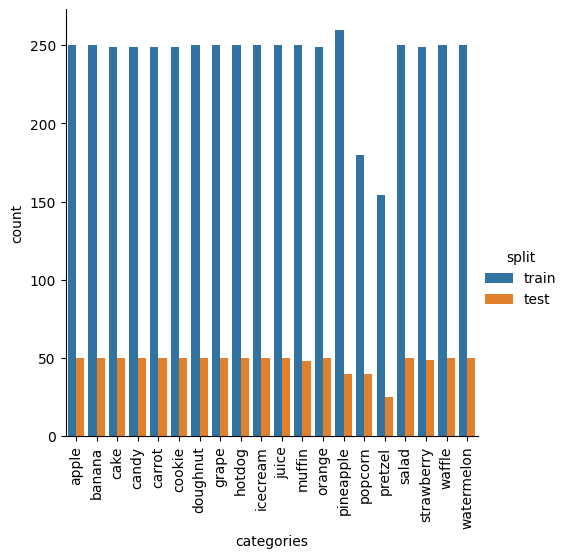

In [477]:
sns.catplot(data=all_counts, x='index', y=0, hue='split', kind='bar')
plt.xlabel('categories')
plt.ylabel('count')
plt.xticks(rotation=90)
plt.show()

Fairly balanced dataset, with the exception of categories 'popcorn' and 'pretzel'.

### Initialize model
Let's load a pretrained ResNet model. Check the documentation (https://huggingface.co/docs/transformers/en/model_doc/resnet, https://huggingface.co/microsoft/resnet-50) for more details on training data, structure, etc.

In [335]:
image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetModel.from_pretrained("microsoft/resnet-50")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Let's now visualize the structure of the model.

In [336]:
model

ResNetModel(
  (embedder): ResNetEmbeddings(
    (embedder): ResNetConvLayer(
      (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (encoder): ResNetEncoder(
    (stages): ModuleList(
      (0): ResNetStage(
        (layers): Sequential(
          (0): ResNetBottleNeckLayer(
            (shortcut): ResNetShortCut(
              (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (layer): Sequential(
              (0): ResNetConvLayer(
                (convolution): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalizatio

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


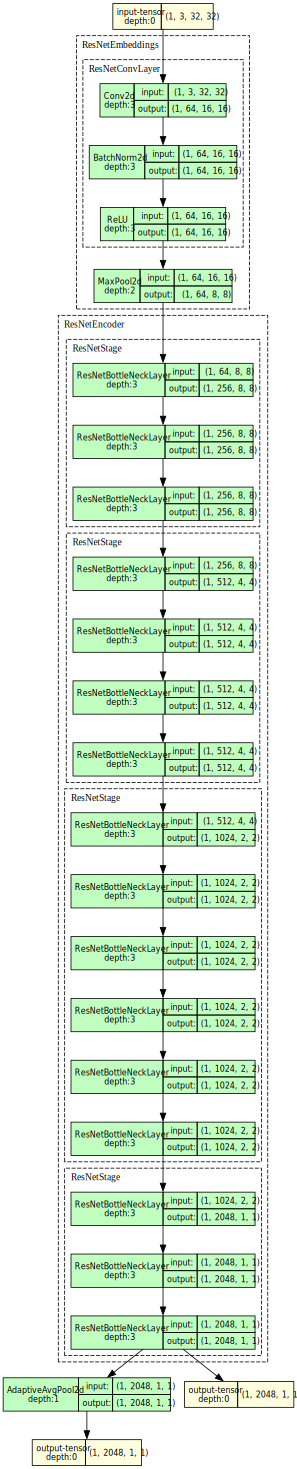

In [479]:
draw_graph(model, input_size=(1,3,224,224), expand_nested=True).visual_graph 

Note: to be able to produce this visualization, I extracted the input size from the preprocessing chunk below (you can do it yourself by printing `input['pixel_values'].shape`).
Reflect a bit on the structure of the model, trying to understand how the types of layers you see map onto what we talked about in class.

### Extract embeddings
Working with training and test (no validation) for simplicity.

In [494]:
train_embeddings = []
test_embeddings = []

In [495]:
def _extract(dataset, outs):
    for i, image in enumerate(dataset['image']):
        inputs = image_processor(image, return_tensors="pt")


        with torch.no_grad():
            outputs = model(**inputs)

        embedding = outputs.pooler_output
        outs.append(embedding.squeeze())
    return torch.stack(tuple(outs))

In [496]:
train_embeddings = _extract(train, train_embeddings)
test_embeddings = _extract(test, test_embeddings)

Let's now visualize the embeddings, to get a feel for whether some information about categories is present.

We will visualize them using t-SNE, a dimensionality reduction method that tries to preserve the similarity structure in high-dimensional spaces.

In [499]:
red = TSNE(2, perplexity=20).fit_transform(train_embeddings)
out = pd.DataFrame(red, columns=['dim1','dim2'])
out['category'] = [label_dict[x] for x in train['label']]

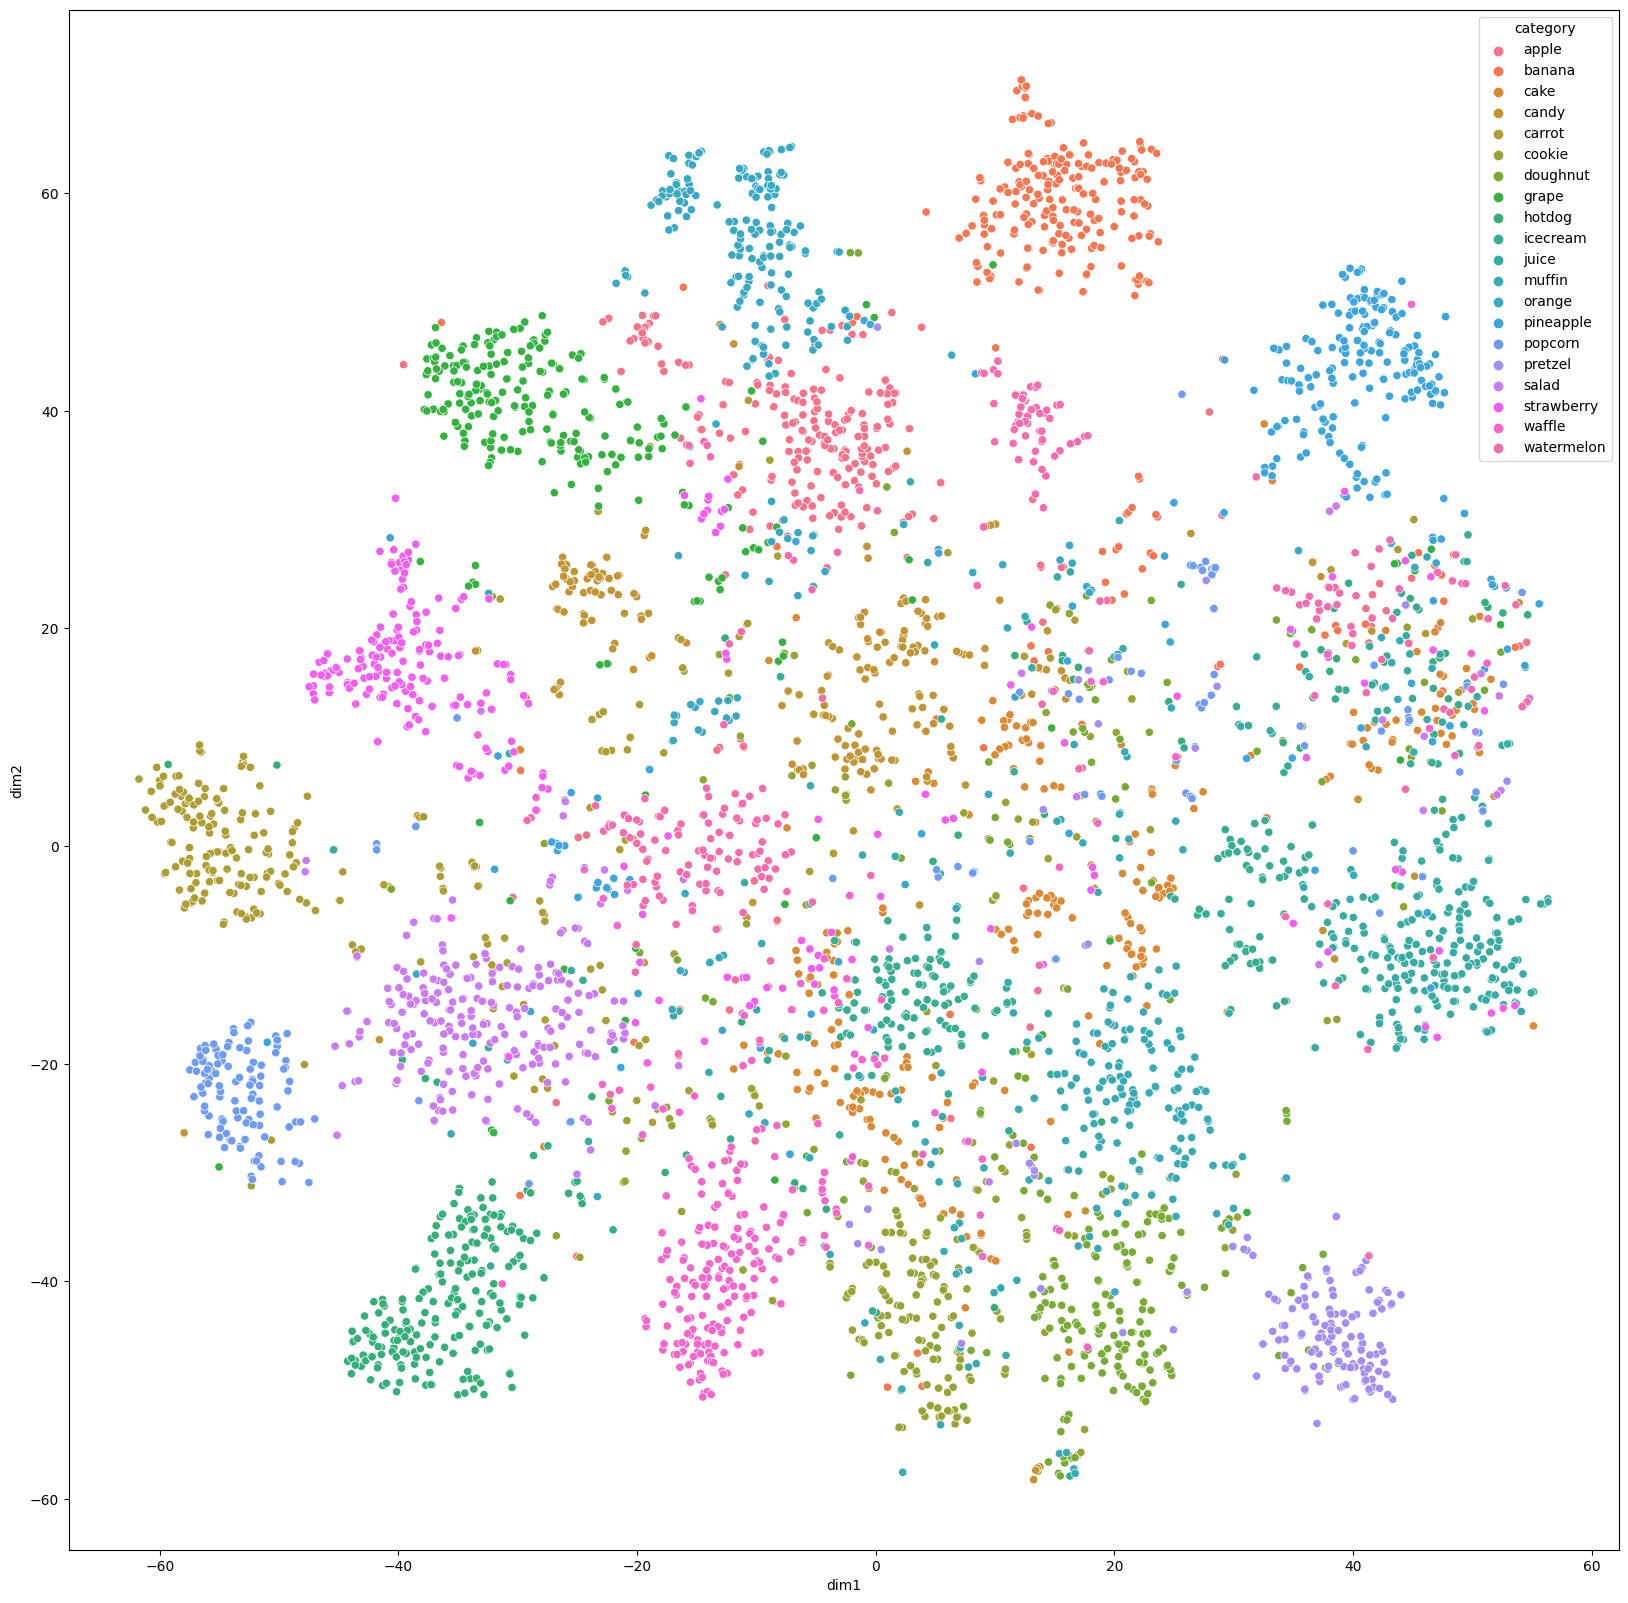

In [500]:
fig, ax = plt.subplots(figsize=(20,20))
sns.scatterplot(data=out, x='dim1', y='dim2', hue='category')
plt.show()

Alright! It seems like the categories are somewhat separated, which means there is hope to find class-related signal in the embeddings.
There is also, though, a fair degree of overlap. We could apply a clustering model as a baseline here, to see which performance we would get without training a predictive model. But let's move straight to training a simple classifier on these embeddings.

### Train and evaluate the classifier

Specifying the structure of our classifier.

In [393]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 20)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Creating a Pytorch Dataset and a Dataloader.

In [394]:
class Embeddings(Dataset):
    def __init__(self, labels, embeddings):
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.embedding = embeddings

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.embedding[idx]
        label = self.labels[idx]
        return image, label

In [395]:
train_dataloader = DataLoader(Embeddings(embeddings=train_embeddings, 
                                         labels=train['label']),
                              batch_size=32, shuffle=True)


Initializing the classifier and specifying loss and optimizer.

In [398]:
net = Classifier()

In [399]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

Here is the training loop. Look back at the neural network notebooks from NLP to refresh these steps if needed.

In [400]:
n_epochs = 2

for epoch in range(n_epochs):  # loop over the dataset multiple times

    for i, data in enumerate(train_dataloader, 0):

        # Get data
        inputs, labels = data

        # Reset gradient gradient
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print loss
        if i % 100 == 0:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {loss}')
            running_loss = 0.0

print('Finished Training')

[1,     1] loss: 3.0047214031219482
[1,   101] loss: 0.7590017318725586
[2,     1] loss: 0.5203213095664978
[2,   101] loss: 0.11431337147951126
Finished Training


And finally, let's evaluate this model. First, let's make predictions on the test set.

In [418]:
preds = []

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i in range(len(test['label'])):
        inputs = test_embeddings[i].reshape(1,-1)
        labels = torch.tensor(test['label'][i], dtype=torch.long).reshape(1,-1)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)       
        preds.append(int(predicted))

Let's compute some overall performance metrics.

In [431]:
print('accuracy', accuracy_score(test['label'], preds))
print('macro f1', f1_score(test['label'], preds, average='macro'))

accuracy 0.8581932773109243
macro f1 0.8603833095091005


Finally, let's get a detailed visualization of performance per category, and error patterns (i.e., which categories are mixed up)

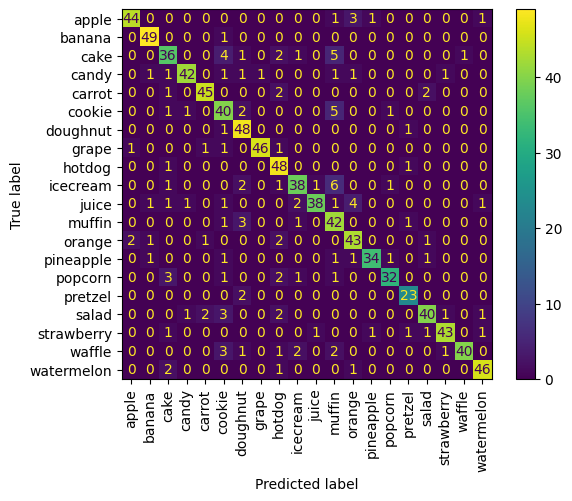

In [428]:
cm = confusion_matrix(test['label'], preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label_dict.values())
disp.plot()
plt.xticks(rotation=90)
plt.show()

### Zero-shot classification with CV models
This is a great option to label images along labels that are not provided explicitly at training. Vision transformers support this behavior, as they are trained as "biencoders", which provides flexibility over the language input.
Try to experiment with a Vision Transformer architecture, labelling images along different dimensions than the ones explored above.

*Note*: You can also do zero-shot classification with text (see slides from lecture)

In [433]:
from transformers import pipeline

checkpoint = "openai/clip-vit-large-patch14"
detector = pipeline(model=checkpoint, task="zero-shot-image-classification")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/utils/generic.py:311: UserWarning:

torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to in

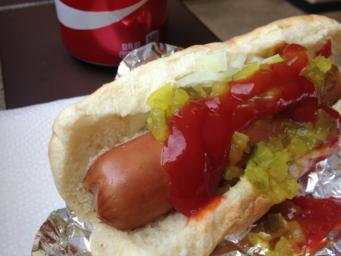

In [468]:
train['image'][2000]

In [466]:
predictions = detector(train['image'][2000], candidate_labels=["one fruit", 
                                                               "many fruits", 
                                                               "non-fruit snack",
                                                               "pastry"])

In [467]:
predictions

[{'score': 0.7688888311386108, 'label': 'non-fruit snack'},
 {'score': 0.17662648856639862, 'label': 'one fruit'},
 {'score': 0.029634922742843628, 'label': 'pastry'},
 {'score': 0.02484971098601818, 'label': 'many fruits'}]

#### Bonus CV tasks
- Try training a classifier on embeddings extracted from a vision transformer: how does performance compare to ResNet?
- Build a CNN from scratch for this classification task: how does performance compare?
- Look up models and pipelines for more computer vision tasks, including semantic segmentation, object detection (which can also be performed zero-shot using ViT), etc.

#### Bonus NN-related tasks
- Train NN-based models (FFNNs or RNNs) on the bike data: how does performance compare to the best algorithms?

### Additional tasks
- A wide array of pretrained models for audio classification (including zero-shot audio classification) are also available on Hugging Face. Experiment with those :)